# Ch11. 텍스트 분류 (Text Classification)

# v03. 로이터 뉴스 분류하기 (Reuters News Classification)

- 이번 챕터에서는 케라스에서 제공하는 로이터 뉴스 데이터를 LSTM을 이용하여 텍스트 분류를 진행해보도록 한다.
- 로이터 뉴스 기사 데이터는 총 11,258개의 뉴스 기사가 46개의 뉴스 카테고리로 분류되는 뉴스 기사 데이터이다.
- 우선 데이터가 어떻게 구성되어 있는 지에 대해서 알아보고, 실습을 진행한다.

<br>

## 3.1 로이터 뉴스 데이터에 대한 이해

In [1]:
from tensorflow.keras.datasets import reuters
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<br>

### 3.1.1 데이터셋 분리

- 케라스 데이터셋으로부터 로이터 뉴스 기사 데이터를 다운로드하고, 뉴스 기사 데이터를 훈련용과 테스트용으로 나눈다.

In [2]:
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

2113536/2110848 [==============================] - 0s 0us/step


- 위에서 `num_words`는 이 데이터에서 등장 빈도 순위로 몇 번째에 해당하는 단어까지만 사용할 것인지를 조절한다.
- 예를 들어서 `100`이란 값을 넣으면, 등장 빈도 순위가 1~100에 해당하는 단어만 사용하게 된다.
- 모든 단어를 사용하고자 한다면 `None`으로 설정한다.
- 아래에서 훈련 데이터를 출력할 때 출력되는 정수들을 보면 이해할 수 있다.

- `test_split`은 전체 뉴스 기사 데이터 중 테스트용 뉴스 기사로 몇 퍼센트를 사용할 것인지를 의미한다.
- 이번 실습에서는 전체 뉴스 기사 중 20%를 테스트용 뉴스 기사로 사용할 것이므로, `0.2`로 설정한다.

In [3]:
print('훈련용 뉴스 기사 : {}'.format(len(X_train)))
print('테스트용 뉴스 기사 : {}'.format(len(X_test)))

훈련용 뉴스 기사 : 8982
테스트용 뉴스 기사 : 2246


<br>

- `y_train`는 0부터 시작하는 숫자들로 카테고리 라벨을 부여한다.
- 그러므로 가장 큰 수에 +1을 하여 출력하면 카테고리가 총 몇 개인지를 알 수 있다.

In [4]:
num_classes = max(y_train) + 1
print('카테고리 : {}'.format(num_classes))

카테고리 : 46


<br>

### 3.1.2 데이터 구성 확인

- 훈련용 뉴스 기사 데이터의 구성을 확인하기 위해 첫 번째 뉴스 기사를 출력해보자.

In [6]:
print(X_train[0]) # 첫 번째 훈련용 뉴스 기사

[1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


- 위와 같이 훈련용 뉴스 기사 데이터인 `X_train` 중 첫 번째 뉴스 기사인 `X_train[0]`에는 정수의 나열이 저장되어 있다.
- 텍스트가 아니라서 의아할 수 있는데, 현재 이 데이터는 **토큰화와 정수 인코딩(각 단어를 정수로 변환)이 끝난 상태**이다.

- 이 데이터는 단어들이 몇 번 등장하는 지의 빈도에 따라서 인덱스를 부여했다.
- `1` 이라는 숫자는 이 단어가 이 데이터에서 등장 빈도가 1등이라는 뜻이다.
- `27,595` 라는 숫자는 이 단어가 데이터에서 27,595번 째로 빈도수가 높은 단어라는 뜻이다.
- 즉, 실제로는 빈도가 굉장히 낮은 단어라는 뜻이다.

- 앞서 `num_words`에다가 `None`을 부여했는 데, 만약 `num_words`에 `1,000`을 넣었다면 빈도수 순위가 1,000 이하의 단어만 가져온다는 의미이므로 데이터에서 1,000을 넘는 정수는 나오지 않는다.

In [7]:
print(y_train[0]) # 첫 번째 훈련용 뉴스 기사의 레이블

3


- 뉴스 기사들의 레이블들을 의미하는 `y_train`에서 첫 번째 뉴스 기사의 레이블인 `y_train[0]`에는 3이라는 값이 들어 있다.
- 이 숫자는 첫 번째 훈련용 뉴스 기사가 46개의 카테고리 중 3에 해당하는 카테고리임을 의미한다.

<br>

- 방금 확인한 `X_train[0]`과 `y_train[0]`은 8,982개의 훈련용 뉴스 기사 중 첫 번째 뉴스 기사의 본문과 레이블만 확인한 것이다.

<br>

### 3.1.3 훈련용 뉴스 기사의 길이 확인

- 이번에는 8,982개의 훈련용 뉴스 기사의 길이가 대체적으로 어떤 크기를 가지는 지 확인해보자.

In [8]:
print('뉴스 기사의 최대 길이 : {}'.format(max(len(l) for l in X_train)))
print('뉴스 기사의 평균 길이 : {}'.format(sum(map(len, X_train)) / len(X_train)))

뉴스 기사의 최대 길이 : 2376
뉴스 기사의 평균 길이 : 145.5398574927633


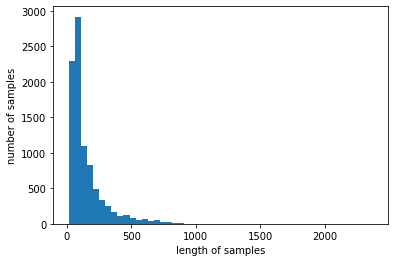

In [9]:
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- 각 뉴스의 길이는 다르며, 대체적으로 대부분의 뉴스가 100~200 사이의 길이를 가지는 것을 알 수 있다.

<br>

### 3.1.4 레이블 값 분포 확인

- 이제 각 뉴스가 어떤 종류의 뉴스에 속하는 지 기재되어 있는 레이블 값의 분포를 살펴보자.

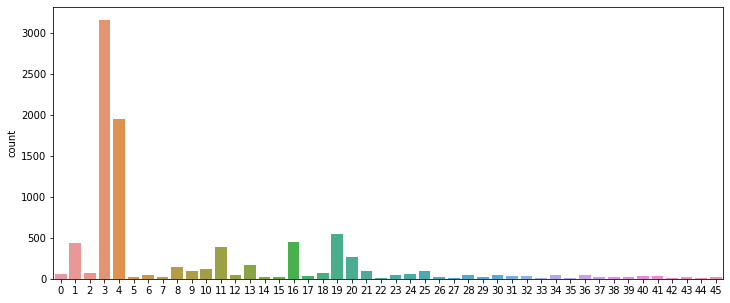

In [13]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12, 5)
sns.countplot(y_train)
plt.show()

- 3, 4가 가장 많은 레이블을 차지하는 것을 확인할 수 있다.

<br>

- 각 레이블에 대한 정확한 개수를 확인해보자.

In [14]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)

print('각 레이블에 대한 빈도수 :')
print(np.asarray((unique_elements, counts_elements)))

각 레이블에 대한 빈도수 :
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


In [15]:
# 위의 출력결과를 병렬로 출력
label_cnt = dict(zip(unique_elements, counts_elements))
print(label_cnt)

{0: 55, 1: 432, 2: 74, 3: 3159, 4: 1949, 5: 17, 6: 48, 7: 16, 8: 139, 9: 101, 10: 124, 11: 390, 12: 49, 13: 172, 14: 26, 15: 20, 16: 444, 17: 39, 18: 66, 19: 549, 20: 269, 21: 100, 22: 15, 23: 41, 24: 62, 25: 92, 26: 24, 27: 15, 28: 48, 29: 19, 30: 45, 31: 39, 32: 32, 33: 11, 34: 50, 35: 10, 36: 49, 37: 19, 38: 19, 39: 24, 40: 36, 41: 30, 42: 13, 43: 21, 44: 12, 45: 18}


- 3번 레이블은 총 3,159개가 존재하고 4번 레이블은 총 1,949개가 존재하는 것을 확인할 수 있다.

<br>

### 3.1.5 정수들이 의미하는 단어들

- `X_train`에 들어 있는 숫자들이 각자 어떤 단어들을 나타내고 있는 지 확인해보자.

In [ ]:
word_to_index = reuters.get_word_index()
print(word_to_index)

```
{'mdbl': 10996, 'fawc': 16260, 'degussa': 12089, 'woods': 8803, 'hanging': 13796, 'localized': 20672, 'sation': 20673, 'chanthaburi': 20675, 'refunding': 10997, 'hermann': 8804, 'passsengers': 20676, 'stipulate': 20677, 'heublein': 8352, 'screaming': 20713, 'tcby': 16261, 'four': 185, 'grains': 1642, 'broiler': 20680, 'wooden': 12090, 'wednesday': 1220, 'highveld': 13797, 'duffour': 7593, '0053': 20681, 'elections': 3914, '270': 2563, '271': 3551, '272': 5113, '273': 3552, '274': 3400, 'rudman': 7975, '276': 3401, '277': 3478, '278': 3632, '279': 4309, 'dormancy': 9381, - 이하 생략 -}
```

- 어떤 단어에 어떤 인덱스가 부여되었는 지를 알 수 있다.
- 하지만 이렇게 보는 것은 불편하다.
- 좀 더 쉽게 확인하기 위해서 인덱스로부터 단어를 바로 알 수 있도록 해보자.

In [ ]:
index_to_word = {}

for key, value in word_to_index.items():
    index_to_word[value] = key

- 이제 `index_to_word[]`에다가 인덱스를 입력하면 단어를 확인할 수 있다.
- `28842`란 인덱스를 가진 단어는 무엇일까?

In [18]:
print('빈도수 상위 28842번 단어 : {}'.format(index_to_word[28842]))

빈도수 상위 28842번 단어 : nondiscriminatory


- "nondiscriminatory"는 잘 쓰이지 않는 단어라서 등장 빈도 순위로 따지면 28,842등이라는 뜻이다.

<br>

- 1번 단어는 무엇일까?

In [19]:
print('빈도수 상위 1번 단어 : {}'.format(index_to_word[1]))

빈도수 상위 1번 단어 : the


- 보통 불용어로 분류되는 "the"가 이 데이터에서도 어김없이 등장 빈도수로 1위를 차지했다.

<br>

### 3.1.6 첫 번째 뉴스 기사 복원

- 이제 `index_to_word`를 이용해서 첫 번째 훈련용 뉴스 기사인 `X_train[0]`가 어떤 단어들로 구성되어 있는 지를 복원해보자.
- 이는 `X_train[0]`에 있는 모든 단어들을 하나씩 불러와서 `index_to_word`의 입력으로 넣고 이를 계속해서 저장하면 된다.
- 아래는 복원된 결과를 보여준다. (물론 정수 인코딩을 수행하기 전에도 어느 정도 전처리가 된 상태라서 제대로된 문장이 나오지는 않는다.)

In [20]:
print(' '.join([index_to_word[X] for X in X_train[0]]))

the wattie nondiscriminatory mln loss for plc said at only ended said commonwealth could 1 traders now april 0 a after said from 1985 and from foreign 000 april 0 prices its account year a but in this mln home an states earlier and rise and revs vs 000 its 16 vs 000 a but 3 psbr oils several and shareholders and dividend vs 000 its all 4 vs 000 1 mln agreed largely april 0 are 2 states will billion total and against 000 pct dlrs


<br>

## 3.2 LSTM으로 로이터 뉴스 분류하기

### 3.2.1 필요 라이브러리 임포트

- 텍스트 분류 작업을 위해 필요한 도구들을 가져온다.

In [ ]:
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

<br>

### 3.2.2 학습에 사용할 데이터셋 추출

- 학습에서는 등장 빈도 순서가 가장 많은 상위 1~1,000번 째인 단어들만 사용한다.

In [ ]:
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=1000, test_split=0.2)

<br>

### 3.2.3 뉴스 기사의 길이 맞추기 (패딩)

- 훈련용 뉴스 기사 데이터와 테스트용 뉴스 기사 데이터에 있는 각각의 뉴스의 길이는 서로 다르다.
- 즉, 각 기사는 단어의 수가 제각각이다.
- 모델의 입력으로 사용하고자 모든 뉴스 기사의 길이를 동일하게 맞춘다.
- `pad_sequences()`를 사용하여 `maxlen`의 값으로 `100`을 준다.
- 이는 모든 뉴스 기사의 길이, 즉 단어 수를 100으로 일치시킨다는 뜻이다.

In [ ]:
max_len = 100
X_train = pad_sequences(X_train, maxlen=max_len) # 훈련용 뉴스 기사 패딩
X_test = pad_sequences(X_test, maxlen=max_len) # 테스트용 뉴스 기사 패딩

- 뉴스 기사에는 분명히 단어의 수가 100개가 넘는 경우도 있을 것이고, 100개가 안되는 경우도 있을 것이다.
- 그렇기 때문에 단어의 개수가 100개보다 많으면 100개만 선택하고 나머지는 제거하며, 100개보다 부족한 경우에는 부족한 부분이 0으로 패딩된다.

<br>

### 3.2.4 레이블 원-핫 인코딩

- 이제 훈련용, 테스트용 뉴스 기사 데이터의 레이블에 원-핫 인코딩을 한다.

In [ ]:
y_train = to_categorical(y_train) # 훈련용 뉴스 기사 레이블의 원-핫 인코딩
y_test = to_categorical(y_test) # 테스트용 뉴스 기사 레이블의 원-핫 인코딩

<br>

### 3.2.5 모델 구성

#### 3.2.5.1 임베딩 층

- 우선 `Embedding()`을 사용하여 임베딩 층(embedding layer)을 만들어야 한다.
- `Embedding()`은 최소 두 개의 인자를 받는다.
  - 첫 번째 인자 : 단어 집합의 크기
  - 두 번째 인자 : 임베딩 벡터의 차원  

- 결과적으로 아래 코드에서 `Embedding()`은 120의 차원을 가지는 임베딩 벡터를 1,000개 생성하는 역할을 한다.

<br>

#### 3.2.5.2 LSTM 층

- 그 후에 샘플들을 `LSTM`에 넣는다.
- `LSTM`의 인자는 메모리 셀의 은닉 상태의 크기(`hidden_size`)이다.

<br>

#### 3.2.5.3 출력층

- 46개의 카테고리를 분류해야 하므로, 출력층에서는 46개의 뉴런을 사용한다.
- 또한 출력층의 활성화 함수로 소프트맥스 함수를 사용한다. (소프트맥스 함수는 각 입력에 대해서 46개의 확률 분포를 만들어낸다.)

In [ ]:
model = Sequential()
model.add(Embedding(1000, 120))
model.add(LSTM(120))
model.add(Dense(46, activation='softmax'))

<br>

### 3.2.6 콜백(Callbacks) 설정

#### 3.2.6.1 학습 조기 종료(Early Stopping) 설정

- 검증 데이터 손실(`val_loss`)이 증가한다는 것은 과적합 징후이다.
- 그러므로 검증 데이터 손실이 4회 증가하면 학습을 **조기 종료(Early Stopping)**한다.

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

<br>

#### 3.2.6.2 모델 저장 체크 포인트 설정

- 또한, `ModelCheckpoint`를 사용하여 검증 데이터의 정확도(`val_acc`)가 이전보다 좋아질 경우에만 모델을 저장한다.

In [ ]:
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

<br>

### 3.2.7 모델 컴파일

- 이 경우 다중 클래스 분류(Multi-Class Classification) 문제이다.
- 그러므로 손실 함수로는 `categorical_crossentropy`를 사용한다.
- `categorical_crossentropy`는 모델의 예측값과 실제값에 대해서 두 확률 분포 사이의 거리를 최소화하도록 훈련한다.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

<br>

### 3.2.8 모델 학습

- `validation_data`로 `X_test`와 `y_test`를 사용한다.
- `val_loss`가 줄어들다가 증가하는 상황이 오면 과적합(overfitting)으로 판단하기 위함이다.

In [29]:
history = model.fit(X_train, y_train,
                    batch_size=128, epochs=30,
                    callbacks=[es, mc], validation_data=(X_test, y_test))

Epoch 1/30
71/71 [==============================] - ETA: 0s - loss: 2.6393 - acc: 0.3334
Epoch 00001: val_acc improved from -inf to 0.46705, saving model to best_model.h5
71/71 [==============================] - 26s 360ms/step - loss: 2.6393 - acc: 0.3334 - val_loss: 2.2866 - val_acc: 0.4671
Epoch 2/30
71/71 [==============================] - ETA: 0s - loss: 2.0551 - acc: 0.4715
Epoch 00002: val_acc improved from 0.46705 to 0.49332, saving model to best_model.h5
71/71 [==============================] - 25s 357ms/step - loss: 2.0551 - acc: 0.4715 - val_loss: 1.9487 - val_acc: 0.4933
Epoch 3/30
71/71 [==============================] - ETA: 0s - loss: 1.8274 - acc: 0.5275
Epoch 00003: val_acc improved from 0.49332 to 0.53963, saving model to best_model.h5
71/71 [==============================] - 26s 360ms/step - loss: 1.8274 - acc: 0.5275 - val_loss: 1.7810 - val_acc: 0.5396
Epoch 4/30
71/71 [==============================] - ETA: 0s - loss: 1.7155 - acc: 0.5507
Epoch 00004: val_acc impro

- 25번 째 에포크에서 훈련이 조기 종료되었다.

<br>

### 3.2.9 모델 성능 평가

- 이제 테스트 데이터에 대해서 정확도를 측정할 차례이다.
- 훈련 과정에서 검증 데이터가 가장 높았을 때 저장된 모델인 `best_model.h5`를 로드하고, 성능을 평가한다.

In [30]:
loaded_model = load_model('best_model.h5')
print('\n 테스트 정확도 : %.4f' % (loaded_model.evaluate(X_test, y_test)[1]))

71/71 [==============================] - 2s 29ms/step - loss: 1.2637 - acc: 0.7102

 테스트 정확도 : 0.7102


- 테스트 데이터에 대한 정확도는 71.02%이다.

<br>

### 3.2.10 검증 데이터와 테스트 데이터

- 케라스의 `model.fit(validation_data)`는 실제 기계가 데이터를 훈련하지는 않고 에포크마다 정확도와 loss를 출력하여 과적합을 판단하기 위한 용도로만 사용된다.
- 그래서 `validation_data`에서 이미 `X_test`, `y_test`를 사용했지만 기계는 아직 이 데이터로 학습한 적이 없는 상태이다.
- 그래서 모델이 학습하지 않은 데이터인 `X_test`, `y_test`를 테스트 데이터로서 성능 평가 용도로 `model.evaluate()`에서도 다시 사용했다.
- 이번 모델은 검증 데이터와 테스트 데이터가 동일한 셈이다.
- 사실 데이터가 충분하다면, 검증 데이터와 테스트 데이터는 다르게 사용하는 것이 좋다.

- `validation_data`에 테스트 데이터인 `X_test`와 `y_test`를 사용했으므로, 결국 가장 높았던 `val_acc`가 `model.evaluate()`로 얻는 테스트 데이터에 대한 정확도와 동일하다.
- 이는 앞서 스팸 메일 분류하기 실습에서 `validation_data` 대신 `validation_split=0.2`를 사용하여 검증 데이터와 테스트 데이터를 다른 데이터를 사용했을 때와는 다른 결과이다.

<br>

### 3.2.11 손실 시각화

- 에포크마다 변화하는 훈련 데이터와 검증 데이터(테스트 데이터)의 손실을 시각화해보자.

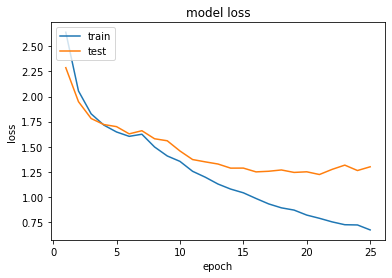

In [31]:
epochs = range(1, len(history.history['acc']) + 1)

plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

- 전체적으로는 검증 데이터의 손실이 줄어드는 경향이 있지만 뒤로 갈수록 점차 검증 데이터의 손실이 증가하려고 하는 경향이 보인다.
- 이는 과적합의 신호일 수 있다.